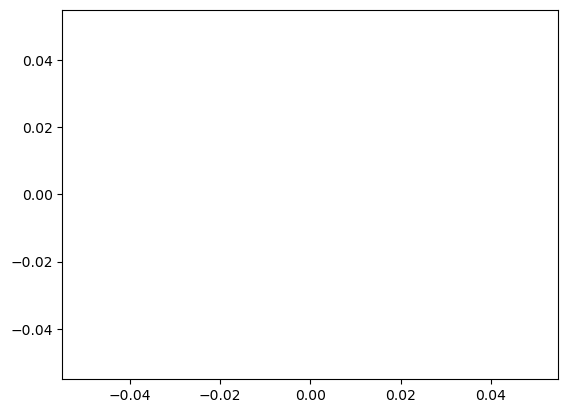

In [90]:
import matplotlib.pyplot as plt
plt.scatter([],[])

In [161]:
import matplotlib.patches as patches
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import random
import cv2
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from IPython.display import clear_output
from urllib.request import urlopen
from PIL import Image
import timm
import shutil

<div style="font-size:32px; line-height:1.4;">
    <b>Гайд по распознаванию букв на изображении:</b><br>
    <br><img src="image.jpeg" alt="Исходное изображение" width="600" height="600">
    <br>Сначала вырежем каждую букву и закрасим в черный
</div>

In [165]:
image_path = "image.jpeg"
image = Image.open(image_path)

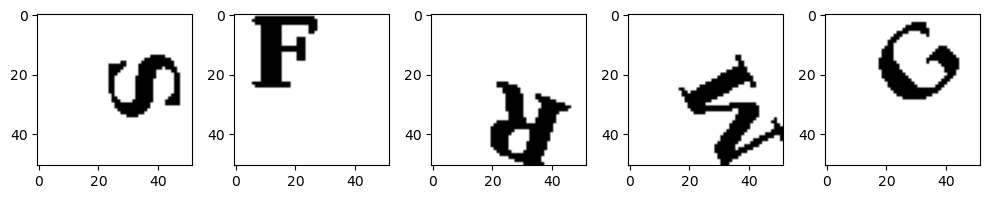

In [163]:
def fit_im_in_box(image):
    
    ht, hb, wt, wb = 0, image.shape[0], 0, image.shape[1]

    ret = np.zeros_like(image)
    for row in range(image.shape[0]):
        for column in range(image.shape[1]):
            if image[row,column] < 100:
                ht = max(ht, row)
                wt = max(wt, column)
                hb = min(hb, row)
                wb = min(wb, column)
                
    new_image = image[hb:ht, wb:wt]
    return new_image

def fit_box_in_white_square(img_small, sz):
    
    img_large = 255 * np.ones((sz,sz))
    
    h_large, w_large = img_large.shape[:2]
    h_small, w_small = img_small.shape[:2]
    center_x, center_y = w_large // 2, h_large // 2

    max_w, max_h = w_large // 2, h_large // 2
    if w_small > max_w or h_small > max_h:
        scale = min(max_w / w_small, max_h / h_small)
        new_w = int(w_small * scale)
        new_h = int(h_small * scale)
        img_small = cv2.resize(img_small, (new_w, new_h))
        h_small, w_small = img_small.shape[:2]
    
    x1 = center_x - w_small // 2
    y1 = center_y - h_small // 2
    x2 = x1 + w_small
    y2 = y1 + h_small

    img_large[y1:y2, x1:x2] = img_small
    return img_large

w, h = image.size
w /= 20
h /= 20
parts = []

for i in range(20):
    for j in range(20):
        
        image_single_crop = image.crop(((i+0.1) * w, (j+0.1) * h,
                                        (i+0.9) * w, (j+0.9) * h))
        image_single_crop = cv2.cvtColor(np.array(image_single_crop), cv2.COLOR_BGR2GRAY)
        
        _, treshold_crop_im = cv2.threshold(image_single_crop, 180, 255, cv2.THRESH_BINARY)
       
        normolised_crop_im = fit_box_in_white_square(fit_im_in_box(treshold_crop_im), 50)

        _, treshold_final_im = cv2.threshold(normolised_crop_im, 180, 255, cv2.THRESH_BINARY)
        
        parts.append(treshold_crop_im )
        
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 9))
for i in range(5):
    axes[i].imshow(parts[np.random.randint(0,len(parts))], cmap='gray')
plt.tight_layout()
plt.show()

<div style="font-size:32px; line-height:1.4;">
    <bк>Создадим и разметим датасет:
</div>

In [6]:
main_dir = 'datasets/Letters_ds/'
train_dir = 'train/'
test_dir = 'test/'

class_names = os.listdir(os.path.join(main_dir, train_dir))

In [42]:
import string

def create_lett_folders(parent_dir):
    os.makedirs(parent_dir, exist_ok=True)
    
    for letter in string.ascii_uppercase:
        folder_path = os.path.join(parent_dir, letter)
        os.makedirs(folder_path, exist_ok=True)

# create_lett_folders(os.path.join(main_dir, train_dir))
# create_lett_folders(os.path.join(main_dir, test_dir))

In [101]:
from pathlib import Path

def remove_data_from_folder(parent):    
    for subfolder in parent.iterdir():
        if subfolder.is_dir():
            for item in subfolder.iterdir():
                try:
                    if item.is_file() or item.is_symlink():
                        item.unlink()
                    elif item.is_dir():
                        shutil.rmtree(item)
                except Exception as e:
                    print(f"Ошибка: {item} - {e}")

# remove_data_from_folder(Path(os.path.join(main_dir, train_dir)))
# remove_data_from_folder(Path(os.path.join(main_dir, test_dir)))

In [33]:
def augment_image(image):
    """
    Применяет случайное масштабирование, растяжение и поворот к изображению.
    
    Параметры:
        image (numpy.ndarray): Входное изображение (BGR или grayscale)
    
    Возвращает:
        numpy.ndarray: Преобразованное изображение
    """
    h, w = image.shape[:2]

    # --- 1. Случайный масштаб и растяжение ---
    # Масштаб по X и Y (например, от 0.8 до 1.5)
    scale_x = random.uniform(0.8, 1.5)
    scale_y = random.uniform(0.8, 1.5)

    # --- 2. Случайный поворот ---
    angle = random.uniform(-180, 180)

    # --- 3. Случайный сдвиг (опционально, чтобы не обрезать края) ---
    tx = random.uniform(-0.1 * w, 0.1 * w)
    ty = random.uniform(-0.1 * h, 0.1 * h)

    # Создаём матрицу аффинного преобразования
    # Сначала поворот и масштаб через getRotationMatrix2D
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)  # без масштаба пока

    # Вручную добавляем масштаб и растяжение
    rot_mat[0, 0] *= scale_x  # cos * scale_x
    rot_mat[0, 1] *= scale_y  # sin * scale_y
    rot_mat[1, 0] *= scale_x
    rot_mat[1, 1] *= scale_y

    # Добавляем сдвиг
    rot_mat[0, 2] += tx
    rot_mat[1, 2] += ty

    # --- Применяем преобразование ---
    # Используем INTER_LINEAR или INTER_CUBIC, BORDER_REFLECT — чтобы заполнить края
    transformed = cv2.warpAffine(
        image, 
        rot_mat, 
        (w, h), 
        flags=cv2.INTER_LINEAR, 
        borderMode=cv2.BORDER_REFLECT
    )
    
    return transformed

In [158]:
LIST = set(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"])

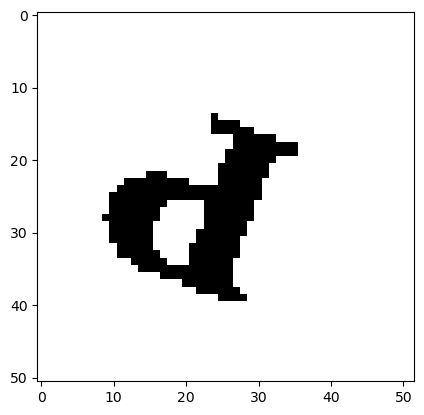

{'T', 'B', 'M', 'R', 'J', 'I', 'W', 'K', 'Z', 'V', 'Y', 'L', 'Q', 'C', 'N', 'A', 'F', 'D', 'G', 'O', 'S', 'X', 'U', 'H', 'E', 'P'}


KeyboardInterrupt: Interrupted by user

In [159]:
%matplotlib inline

while LIST:
    
    n = np.random.randint(0, len(parts))
    to_save = np.array(parts[n])
    plt.imshow(np.array(to_save), cmap='gray')
    plt.pause(0.1) 

    print(LIST)
    
    lette = input()
    
    if lette == '':
        lette = "not_to_save"

    if lette in LIST:
        LIST.discard(lette)
        for _ in range(200):
            cv2.imwrite(os.path.join(main_dir ,train_dir,f'{lette}', f'{random.random()}.bmp'), augment_image(to_save))

    clear_output(True)

In [167]:
# n+=1
# to_save = np.array(parts[n])
# plt.imshow(np.array(to_save), cmap='gray')

In [168]:
# lette = input()
# for _ in range(50):
#     cv2.imwrite(os.path.join(main_dir ,train_dir,f'{lette}', f'{random.random()}.bmp'), rotate_image(to_save))

In [104]:
def move_to_test(n):
    for subfolder_name in os.listdir(os.path.join(main_dir, train_dir)):
        source_subfolder = os.path.join(main_dir, train_dir, subfolder_name)
        destination_subfolder = os.path.join(main_dir, test_dir, subfolder_name)
    
        if os.path.isdir(source_subfolder):
            files = os.listdir(source_subfolder)
            
            for i in range(n):
                if i < len(files):
                    source_file = os.path.join(source_subfolder, files[i])
                    destination_file = os.path.join(destination_subfolder, files[i])
                    shutil.move(source_file, destination_file)

#move_to_test(30)

<div style="font-size:32px; line-height:1.4;">
    <bк>Создадим и обучим классификатор (в данном случае берется предобученный ViT-16-224 из библиотеки timm):
</div>

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
classes = 26

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.ViT = timm.create_model('vit_base_patch16_224.mae', pretrained=True)
        self.fc1 = nn.Linear(768, classes)
        
    def forward(self, X):
        
        X = self.ViT(X)
        X = self.fc1(X)
        
        return X
        
model = Model().to(device)
epoche = 0
test_acc = None

<div style="font-size:32px; line-height:1.4;">
    <bк>Поварьируем гиперепараметры для лучшей сходимости:
</div>

In [152]:
epochs = 5
learning_rate = 0.00001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.00001)

train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomAffine(degrees=(0, 360), translate=(0.1, 0.1), scale=(0.9, 1), fill=255),
                                       transforms.RandomResizedCrop(size=(224, 224),scale=(0.8, 1.2),  ratio=(0.75, 1.33)),
                                       transforms.ToTensor()
                                      ])
test_transforms = train_transforms

BATCH_SIZE = 16

train_data = datasets.ImageFolder(os.path.join(main_dir, train_dir), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(main_dir, test_dir), transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


In [153]:
for cur in range(epochs):
    epoche += 1
    
    obj_number = 0
    correct_obj = 0

    for x, y in train_loader:
 
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        _, prediction = torch.max(outputs.data, 1)
        loss.backward()
        optimizer.step()
      
        obj_number += labels.size(0)
        correct_obj += (prediction == labels).sum().item()
    
        print(f"Эпоха: {epoche} , датасет пройден на {round(100*obj_number/len(train_data),2)}%, точность по обучающему {round(100*correct_obj/obj_number,2)}%, точность тестирования прошлой эпохи {round(100*test_acc,2) if test_acc else 0.00}%        ",
              sep='', end='\r')
    

    test_total = 0
    test_correct = 0    
    with torch.no_grad():
            for test_images, test_targets in test_loader:
    
                images, targets = test_images.to(device), test_targets.to(device)
                test_outputs = model(images)
                difference = criterion(test_outputs, targets)
                
                _, test_pred = torch.max(test_outputs.data, 1)

                test_total += targets.size(0)
                test_correct += (test_pred == targets).sum().item()
    to_comp = test_acc            
    test_acc = test_correct/test_total

    dynamic = test_acc - to_comp if to_comp else 0.0
    
    if cur == epochs - 1:
        print(f"Эпоха: {epoche} завершена, датасет пройден на {round(100*obj_number/len(train_data),2)}%, точность по обучающему {round(100*correct_obj/obj_number,2)}%, точность тестирования данной эпохи {round(100*test_acc,2) if test_acc else 0.00}% Δ{round(100*dynamic,2)}%        ",
              sep='', end='\r')

KeyboardInterrupt: 

<div style="font-size:32px; line-height:1.4;">
    <bк>Протестируем модель:
</div>

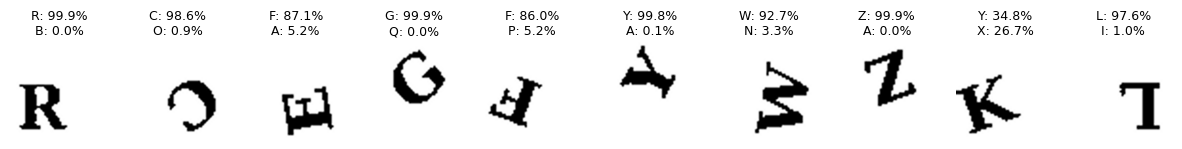

In [156]:
num_images = 10
selected_indices = np.random.choice(len(parts), size=num_images, replace=len(parts) >= 5)

# Подготовим фигуру для 5 изображений
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
if num_images == 1:
    axes = [axes]
plt.subplots_adjust(wspace=0.2)

for idx, ax in zip(selected_indices, axes):
    image = parts[idx]

    # Конвертация в numpy
    if isinstance(image, np.ndarray):
        img_np = image
    else:
        img_np = np.array(image)

    # Конвертация в 3 канала (RGB), если нужно
    if len(img_np.shape) == 2:
        img_np = np.stack([img_np] * 3, axis=-1)  # (H, W) -> (H, W, 3)
    elif img_np.shape[2] == 1:
        img_np = np.stack([img_np.squeeze()] * 3, axis=-1)  # (H, W, 1) -> (H, W, 3)
    elif img_np.shape[2] == 4:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGRA2BGR)  

    # Ресайз до 224x224
    img_resized = cv2.resize(img_np, (224, 224), interpolation=cv2.INTER_CUBIC)

    # Конвертация в тензор
    img_tensor = torch.tensor(img_resized).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).to(device)  # (1, C, H, W)

    # Предсказание
    with torch.no_grad():
        pred = model(img_tensor)
        probs = torch.nn.functional.softmax(pred[0], dim=0)
        top2 = torch.topk(probs, 2)

    # Отображение
    ax.imshow(img_resized)  # корректные цвета в matplotlib
    ax.axis("off")

    # Подпись: топ-2 класса
    label_text = "\n".join([
        f"{class_names[top2.indices[i].item()]}: {top2.values[i].item()*100:.1f}%"
        for i in range(2)
    ])
    ax.set_title(label_text, fontsize=9, pad=4)

plt.show()